# A simpl(er) Introduction to Hierarchical Models 
### Naive Bayesians, 2021


### Agenda

1. Univariate Model (Radon Gas)
    * Pooled 
    * Unpooled 
    * Hierarchical 

2. Multivariate model (Synthetic Data)
    * Pooled 
    * Unpooled 
    * Hierarchical 

#### Notebook Setup

In [1]:
%load_ext nb_black
%reload_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML

display(HTML("<style>.container { width:85% !important; }</style>"))

<IPython.core.display.Javascript object>

In [29]:
import os
from scipy import stats
import pandas as pd
import numpy as np
from typing import Dict

# ML libraries
import pymc3 as pm
from sklearn.linear_model import LinearRegression

# Plotting and viz
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["font.size"] = 15

<IPython.core.display.Javascript object>

## Univariate Regression - Radon Gas Example

Suppose the radon concentration for a specific house, $i$, in county, $c$ is related to if the house has a basement with the relationship:  

$$
\begin{align*}
\text{Pooled:  } \text{log_radon}_{i, c} = {} & \alpha + \beta \hspace{1mm} \text{floor}_{i, c} + \epsilon_{i, c}, \\
\text{Unpooled:  }  \text{log_radon}_{i, c} = {} & \alpha_{c} + \beta_{c} \hspace{1mm} \text{floor}_{i, c} + \epsilon_{i, c}
\end{align*}
$$

where $\alpha_{c}$ is the average radon concentration, $\text{floor}_{i, c}  = 0$ if the house has a basement  $\text{floor}_{i, c}  = 1$ if the house doesn't have a basement. 

In [3]:
# Load data
def load_radon_data() -> pd.DataFrame:
    data = pd.read_csv(pm.get_data("radon.csv"))
    data = data[["county", "floor", "log_radon"]]
    return data


radon_data = load_radon_data()

counties = radon_data["county"].drop_duplicates().to_list()

print(f"Num counties: {len(counties)}")

# Map each county with an index
county_index_mapping = {county: index for index, county in enumerate(counties)}

radon_data = radon_data.assign(
    **{"county_index": lambda x: x["county"].map(county_index_mapping)}
)
display(radon_data)

Num counties: 85


,county,floor,log_radon,county_index
0,AITKIN,1.0,0.832909,0
1,AITKIN,0.0,0.832909,0
2,AITKIN,0.0,1.098612,0
3,AITKIN,0.0,0.095310,0
4,ANOKA,0.0,1.163151,1
...,...,...,...,...
914,WRIGHT,0.0,1.871802,83
915,WRIGHT,0.0,1.526056,83
916,WRIGHT,0.0,1.629241,83
917,YELLOW MEDICINE,0.0,1.335001,84


<IPython.core.display.Javascript object>

### 1. Pooled Model Radon Gas Example

In [22]:
# Build individual models
with pm.Model() as ind_radon_model:
    # Prior
    # ---> Regression Coefficients
    alpha = pm.Normal("alpha", mu=0, sigma=10, shape=1)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=1)
    # ---> Noise
    eps = pm.HalfCauchy("eps", 5)

    # Likelihood
    mu = alpha + beta * radon_data["floor"]
    y = pm.Normal("obs", mu=mu, sigma=eps, observed=radon_data["log_radon"])

    # Posterior
    trace = pm.sample(draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 35 seconds.


<IPython.core.display.Javascript object>

/opt/anaconda3/envs/homework/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


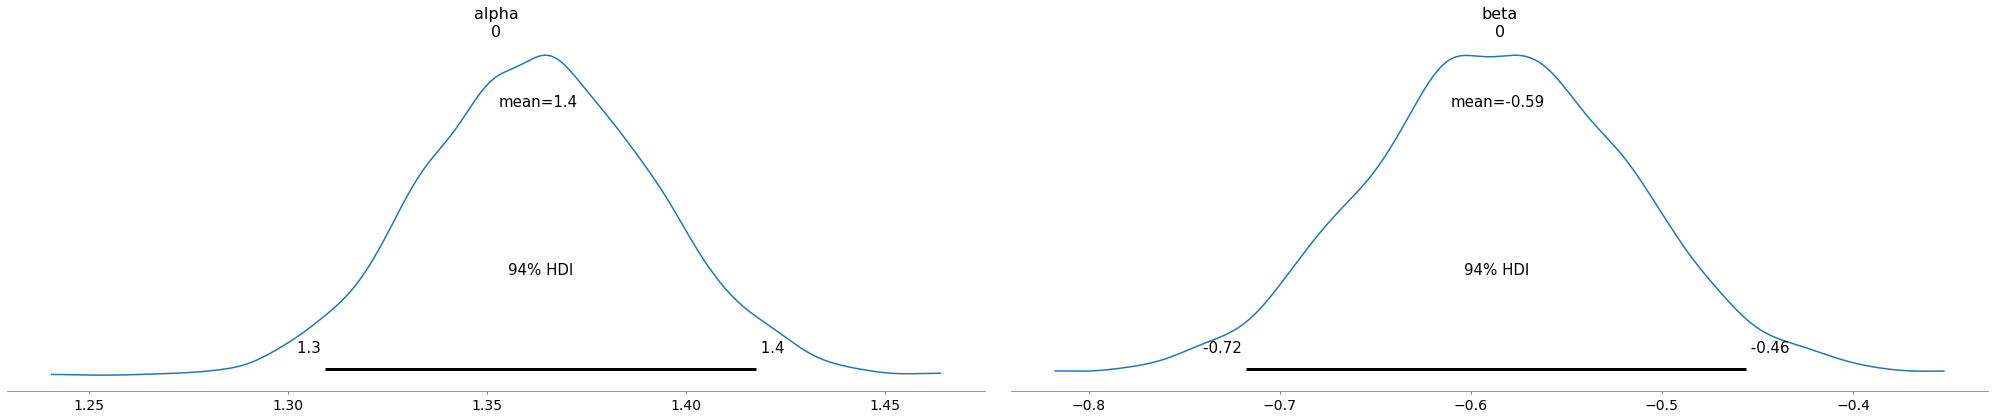

<IPython.core.display.Javascript object>

In [30]:
pm.plot_posterior(trace, var_names=["alpha", "beta"])
plt.show()

In [31]:
with ind_radon_model:
    display(pm.summary(trace))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],1.363,0.029,1.309,1.418,0.000,0.000,3981.0,3977.0,3952.0,2799.0,1.0
beta[0],-0.586,0.070,-0.718,-0.456,0.001,0.001,4030.0,4030.0,4022.0,2914.0,1.0
eps,0.791,0.019,0.754,0.823,0.000,0.000,4732.0,4732.0,4691.0,2674.0,1.0


<IPython.core.display.Javascript object>

### 2. Unpooled Model Radon Gas Example

In [4]:
# Build individual models
with pm.Model() as unpooled_radon_model:
    # Prior
    # ---> Regression Coefficients
    alpha = pm.Normal("alpha", mu=0, sigma=10, shape=len(counties))
    beta = pm.Normal("beta", mu=0, sigma=10, shape=len(counties))
    # ---> Noise
    eps = pm.HalfCauchy("eps", 5)

    # Likelihood
    mu = (
        alpha[radon_data["county_index"]]
        + beta[radon_data["county_index"]] * radon_data["floor"]
    )
    y = pm.Normal("obs", mu=mu, sigma=eps, observed=radon_data["log_radon"])

    # Posterior
    trace = pm.sample(draws=2000)

/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 109 seconds.
/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


<IPython.core.display.Javascript object>

In [6]:
with unpooled_radon_model:
    display(pm.summary(trace))

/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.684,0.414,-0.091,1.456,0.005,0.004,7009.0,5077.0,7007.0,3015.0,1.0
alpha[1],0.954,0.103,0.754,1.140,0.001,0.001,7805.0,7605.0,7809.0,2752.0,1.0
alpha[2],1.462,0.700,0.147,2.724,0.008,0.007,6961.0,5692.0,6941.0,3088.0,1.0
alpha[3],1.711,0.410,0.965,2.481,0.005,0.003,7315.0,7043.0,7352.0,3026.0,1.0
alpha[4],1.335,0.413,0.562,2.110,0.005,0.004,6832.0,5196.0,6978.0,3264.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
beta[81],-0.039,9.974,-17.492,19.694,0.109,0.208,8317.0,1147.0,8316.0,2630.0,1.0
beta[82],-1.971,0.467,-2.884,-1.129,0.006,0.004,6981.0,6757.0,6994.0,3458.0,1.0
beta[83],-0.790,0.752,-2.250,0.538,0.009,0.009,7531.0,3541.0,7549.0,3225.0,1.0
beta[84],-0.090,9.954,-18.948,18.270,0.101,0.194,9627.0,1316.0,9618.0,2414.0,1.0


<IPython.core.display.Javascript object>

### 3. Hierarchical Model Radon Gas Example

In [7]:
# Build individual models
with pm.Model() as hierarchical_radon_model:
    # Prior
    # -> Global prior
    mu_alpha_glob = pm.Normal("mu_alpha", mu=0, sigma=10)
    sigma_alpha_glob = pm.HalfCauchy("sig_alpha", 5)

    mu_beta_glob = pm.Normal("mu_beta", mu=0, sigma=10)
    sigma_beta_glob = pm.HalfCauchy("sig_beta", 5)

    # ---> Regression Coefficients
    alpha = pm.Normal(
        "alpha", mu=mu_alpha_glob, sigma=sigma_alpha_glob, shape=len(counties)
    )
    beta = pm.Normal(
        "beta", mu=mu_beta_glob, sigma=sigma_beta_glob, shape=len(counties)
    )
    # ---> Noise
    eps = pm.HalfCauchy("eps", 5)

    # Likelihood
    mu = (
        alpha[radon_data["county_index"]]
        + beta[radon_data["county_index"]] * radon_data["floor"]
    )
    y = pm.Normal("obs", mu=mu, sigma=eps, observed=radon_data["log_radon"])

    # Posterior
    trace = pm.sample(draws=2000)

/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha, sig_beta, mu_beta, sig_alpha, mu_alpha]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 144 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


<IPython.core.display.Javascript object>

In [8]:
with hierarchical_radon_model:
    display(pm.summary(trace))

/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_alpha,1.491,0.053,1.394,1.589,0.002,0.001,821.0,807.0,837.0,1007.0,1.00
mu_beta,-0.644,0.082,-0.800,-0.492,0.003,0.002,562.0,562.0,565.0,768.0,1.01
alpha[0],1.210,0.247,0.753,1.665,0.004,0.003,3330.0,3330.0,3357.0,2947.0,1.00
alpha[1],0.990,0.095,0.820,1.170,0.002,0.001,3597.0,3519.0,3610.0,2376.0,1.00
alpha[2],1.509,0.262,1.016,1.986,0.005,0.003,2859.0,2859.0,2852.0,2764.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
beta[83],-0.655,0.281,-1.223,-0.147,0.005,0.004,3648.0,2172.0,3299.0,1942.0,1.02
beta[84],-0.639,0.308,-1.255,-0.077,0.005,0.004,3624.0,2642.0,3242.0,1691.0,1.01
sig_alpha,0.326,0.046,0.241,0.411,0.001,0.001,1030.0,1030.0,1028.0,2124.0,1.00
sig_beta,0.273,0.115,0.040,0.459,0.016,0.011,52.0,52.0,41.0,15.0,1.05


<IPython.core.display.Javascript object>

## Multivariate Model - Synthetic Example

### Data Model

Suppose you have data from 2 different sites. 
\begin{align*}
y_{a, i} =  \pmb{w}_{a}^\textsf{T}\pmb{x}_{a, i} + \epsilon_{i}  \;\;\;\;
y_{b, i} = \pmb{w}_{b}^\textsf{T}\pmb{x}_{b, i} + \epsilon_{i} \\
\end{align*}



The data can be collected into a observation vector as follows:
\begin{align*}
\pmb{y} = {} & \begin{bmatrix} \pmb{y}_{a} \\   \pmb{y}_{b} \end{bmatrix} \;\;\;\;
\end{align*}

where, the observations from the indiviual sites as
\begin{align*}
\pmb{y}_{a} = {} & \begin{bmatrix}y_{a, 1} \\ \vdots \\  y_{a, N_{a}}  \end{bmatrix}  \;\;\;\;
\pmb{y}_{b} =  \begin{bmatrix}y_{b, 1} \\ \vdots \\  y_{b, N_{b}}  \end{bmatrix} \\
\end{align*}

#### Vectorised representation

So the observations can be expressed as: 

\begin{align*}
\pmb{y}_{a} = {} & \pmb{X}_{a}\pmb{w}_{a} + \pmb{\epsilon} \;\;\;\;
\pmb{y}_{b} =   \pmb{X}_{b}\pmb{w}_{b} + \pmb{\epsilon}  \\
\end{align*}

The regressors (or inputs), $\pmb{x}$ can be collected into a matrix 
\begin{align*}
\pmb{X}_{a}= {} & \begin{bmatrix} \pmb{x}^\textsf{T}_{a, 1} \\ \vdots \\  \pmb{x}^\textsf{T}_{a, N_{a}}  \end{bmatrix} \;\;\;\;
\pmb{X}_{b}=  \begin{bmatrix} \pmb{x}^\textsf{T}_{b, 1} \\ \vdots \\  \pmb{x}^\textsf{T}_{b, N_{b}}  \end{bmatrix} \\
\end{align*}

and the data from the 2 sites, $a$ and $b$ can be augmented as, 
$
\begin{align*}
\pmb{X} = {} & \begin{bmatrix} \pmb{X}_{a} \\   \pmb{X}_{b} \end{bmatrix}.
\end{align*}
$

In [36]:
n = 1000
w_opt_a = np.array([1, 3.5, 6])
w_opt_b = np.array([-1, -3.5, -6])
m = len(w_opt_a)

X = stats.norm.rvs(size=(n * 2, m), loc=0, scale=1)

X_a, X_b = X[0:n], X[n:]


y = np.append((X_a @ w_opt_a), (X_b @ w_opt_b)) + stats.norm.rvs(
    size=n * 2, loc=0, scale=0.5
)

<IPython.core.display.Javascript object>

### 1. Pooled Model 

The pooled model considers both the data set (Least squares solution)


$$
\begin{align*}
\hat{\pmb{w}}_{\textsf{pooled}} = \left(\pmb{X}^\textsf{T} \pmb{X} \right)^{-1} \pmb{X}^\textsf{T}\pmb{y}
\end{align*}
$$


In [13]:
w = np.linalg.inv((X.T @ X)) @ (X.T @ y)
print("Direct computation", w)

lin_mod = LinearRegression(fit_intercept=False)
lin_mod.fit(X, y)
print("Sklearn Linear Regession", lin_mod.coef_)

Direct computation [-0.07798864 -0.04987297 -0.25394339]
Sklearn Linear Regession [-0.07798864 -0.04987297 -0.25394339]


<IPython.core.display.Javascript object>

#### Pooled Model (Bayesian)

In [14]:
with pm.Model() as mod:
    w_ = pm.Normal(name="w", mu=0, sigma=10, shape=m)
    sigma = pm.InverseGamma("sigma", mu=1, sigma=10)
    obs = pm.Normal(name="obs", observed=y, mu=X @ w_, sigma=sigma)
    trace = pm.sample(draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, w]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 42 seconds.


<IPython.core.display.Javascript object>

/opt/anaconda3/envs/homework/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


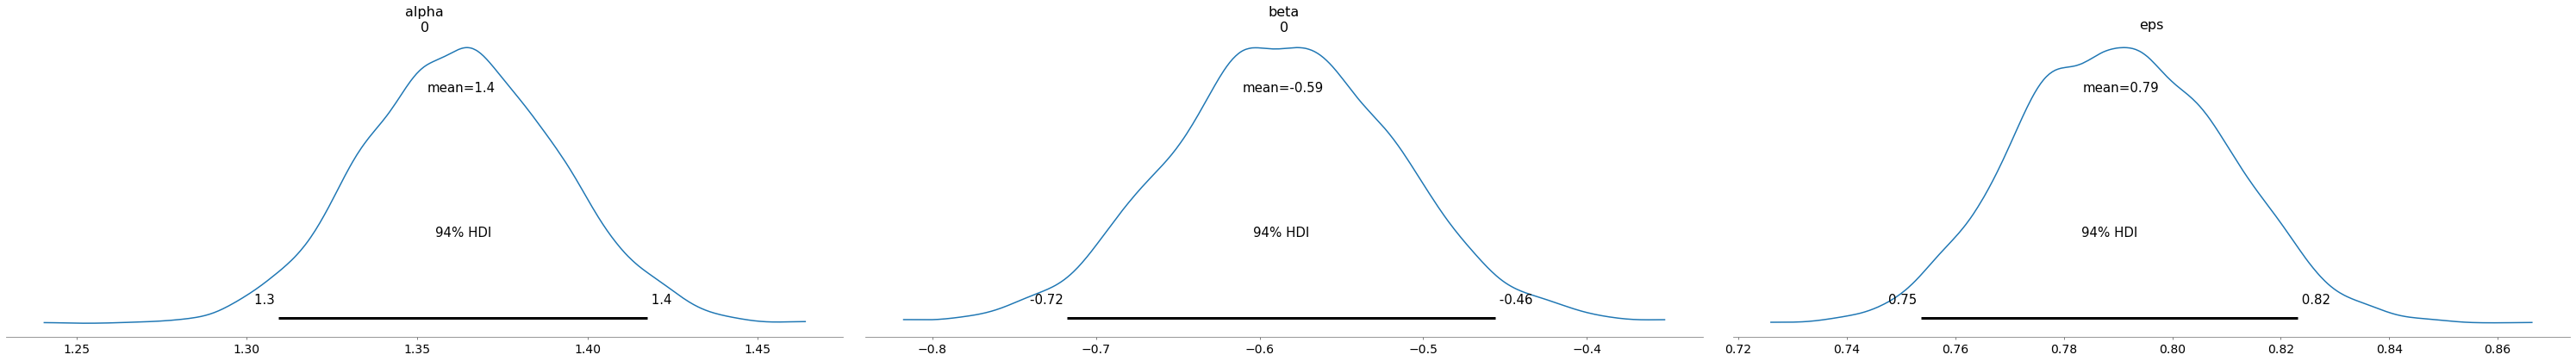

<IPython.core.display.Javascript object>

In [33]:
pm.plot_posterior(trace)
plt.show()

### 2. Unpooled Model 

#### Representation  

Since, we'd like to estimate the individual parameters from site $a$ & $b$, the 2 vectors can be augmented as
$
\begin{align*}
\hat{\pmb{w}} =  \begin{bmatrix}  \hat{\pmb{w}}_a  ,   \hat{\pmb{w}}_b\end{bmatrix} 
\end{align*}
$ to give us a $(M \times 2)$ matrix

As seen before the regressors can be augmened into a $(N_a + N_b) \times m$ matrix,
$
\begin{align*}
\pmb{X} = {} & \begin{bmatrix} \pmb{X}_{a} \\   \pmb{X}_{b} \end{bmatrix}. 
\end{align*}
$

To get to our observations, we first multiple the regressors and the regression coefficients as follows

\begin{align*}
\tilde{\pmb{y}} = {} & \pmb{X} \hat{\pmb{w}}   \\
 = {} & \begin{bmatrix} \pmb{X}_{a} \\   \pmb{X}_{b} \end{bmatrix} \begin{bmatrix}  \hat{\pmb{w}}_a  ,   \hat{\pmb{w}}_b\end{bmatrix} \\
  = {} & \begin{bmatrix} \hat{\pmb{y}}_{a}, \ \tilde{\pmb{y}}_{ab} \\  \tilde{\pmb{y}}_{ba}, \hat{\pmb{y}}_{b} \end{bmatrix} 
\end{align*}

This gives us an augmented observation matrix of size $(N_a + N_b) \times 2$. Recall that our observations are a _vector_ of the size $(N_a + N_b) \times 1$, i.e.

\begin{align*}
\hat{\pmb{y}} = {} & \begin{bmatrix} \hat{\pmb{y}}_{a} \\ \hat{\pmb{y}}_{b} \end{bmatrix} 
\end{align*}

So, to extract a the observation vector $\hat{\pmb{y}}$ from the augmented matrix $\tilde{\pmb{y}}$, we need to access the 
correct elements: 
\begin{align*}
\hat{\pmb{y}} = {} & \tilde{\pmb{y}}\textsf{.iloc}\left( \begin{bmatrix} 0 & 0 \\ 1 & 0 \\ \vdots & 0 \\ N_a & 0 \\ N_a + 1 & 1 \\ N_a + 2 & 1 \\ \vdots & 1 \\ N_a + N_b & 1 \end{bmatrix}  \right)
\end{align*}



In [37]:
index_cols = np.append(
    np.zeros(len(X_a), dtype=np.int8), np.ones(len(X_b), dtype=np.int8)
)
index_rows = np.arange(len(X_a) + len(X_b))

with pm.Model() as ind_mod:
    # Prior
    # -> Individial priors
    w_ind = pm.Normal(name="w", mu=0, sigma=10, shape=(m, 2))
    sigma = pm.InverseGamma("sigma", mu=1, sigma=10)

    # Likelihood
    mu = (X @ w_ind)[index_rows, index_cols]
    obs = pm.Normal(name="obs", observed=y, mu=mu, sigma=sigma)
    
    # Sample from the posterior
    trace = pm.sample(draws=1500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, w]


Sampling 2 chains for 1_000 tune and 1_500 draw iterations (2_000 + 3_000 draws total) took 58 seconds.
/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


<IPython.core.display.Javascript object>

In [38]:
trace.get_values(varname="w").shape

(3000, 3, 2)

<IPython.core.display.Javascript object>

/opt/anaconda3/envs/homework/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


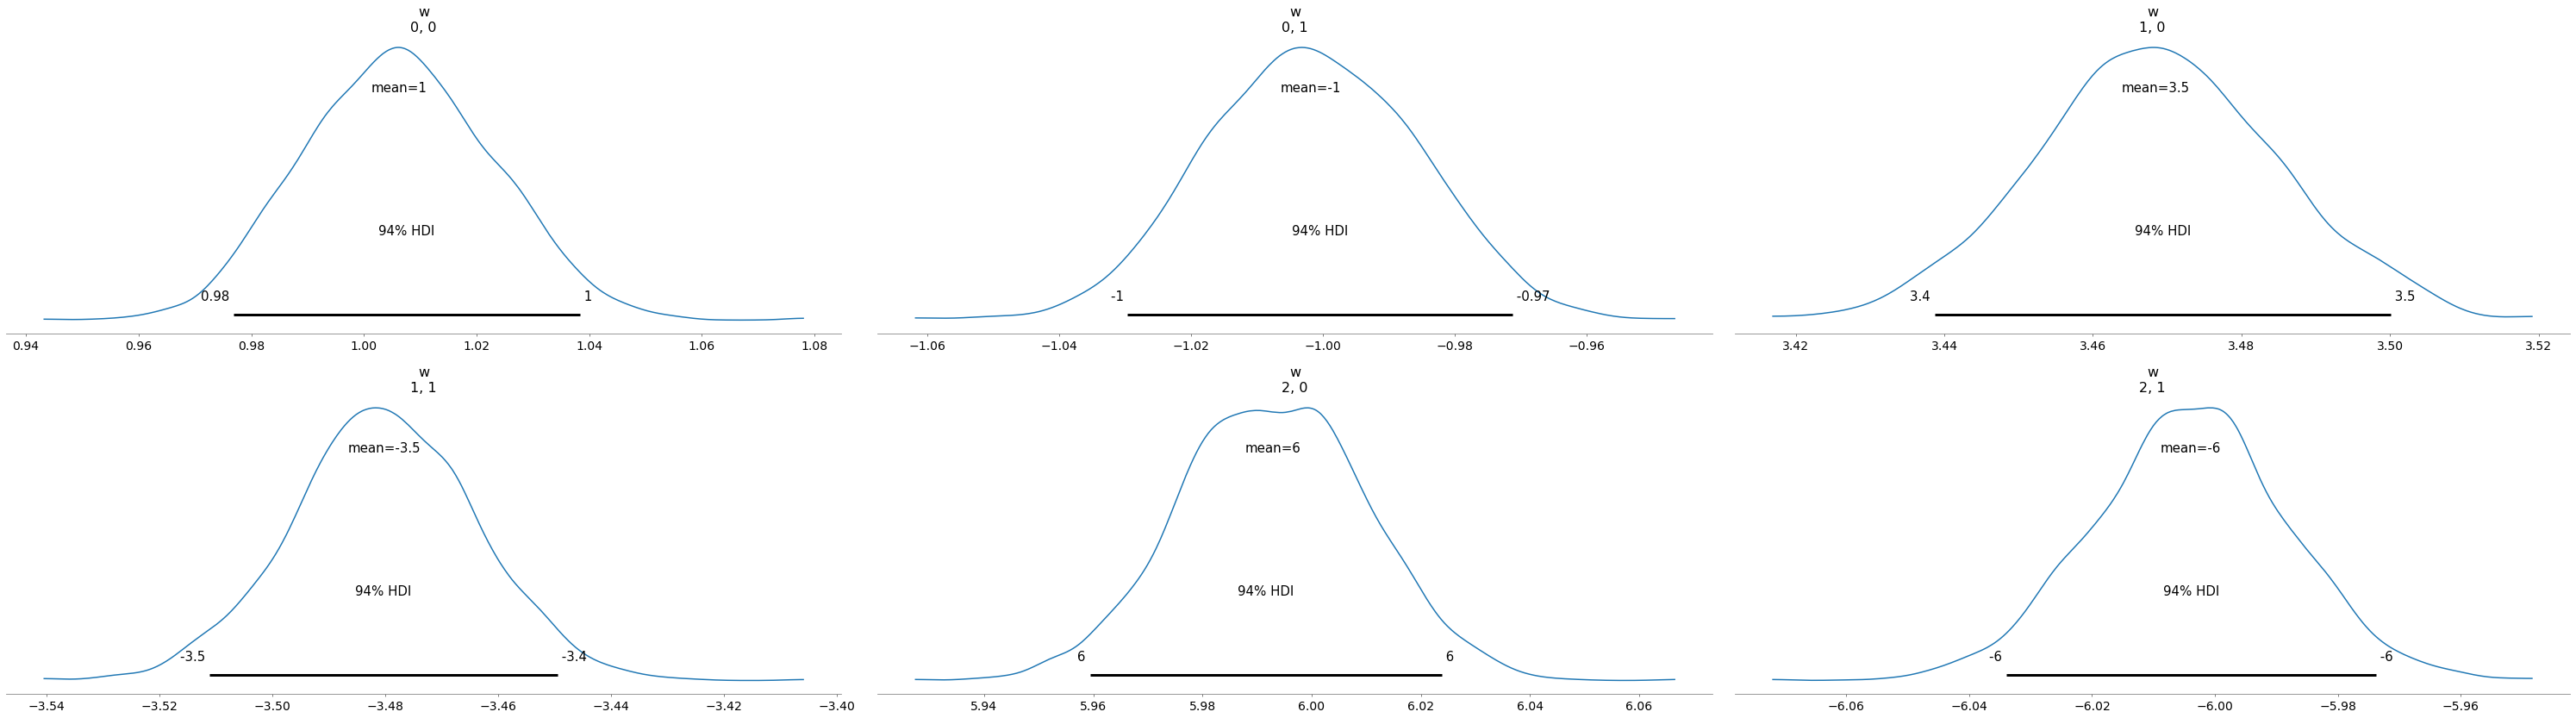

<IPython.core.display.Javascript object>

In [39]:
pm.plot_posterior(trace, var_names=["w"])
plt.show()

In [40]:
with ind_mod:
    display(pm.summary(trace))

/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"w[0,0]",1.006,0.017,0.977,1.038,0.0,0.0,5019.0,4995.0,5060.0,2329.0,1.0
"w[0,1]",-1.002,0.016,-1.030,-0.971,0.0,0.0,6590.0,6588.0,6548.0,2412.0,1.0
"w[1,0]",3.468,0.016,3.439,3.500,0.0,0.0,5401.0,5397.0,5387.0,2359.0,1.0
"w[1,1]",-3.480,0.016,-3.511,-3.449,0.0,0.0,4511.0,4511.0,4506.0,2369.0,1.0
"w[2,0]",5.993,0.017,5.959,6.024,0.0,0.0,4817.0,4817.0,4878.0,2303.0,1.0
"w[2,1]",-6.004,0.016,-6.034,-5.974,0.0,0.0,4799.0,4797.0,4795.0,2601.0,1.0
sigma,0.515,0.008,0.499,0.530,0.0,0.0,5182.0,5182.0,5158.0,2254.0,1.0


<IPython.core.display.Javascript object>

In [ ]:
with pm.Model() as hierarchical_mod:
    # Prior

    # -> Global Prior
    mu_w_glob = pm.Normal(name="mu_w", mu=0, sigma=10, shape=(m, 1))
    sigma_w_glob = pm.InverseGamma("sigma_w", mu=1, sigma=10)

    # -> Individial priors
    w_hierarchy = pm.Normal(name="w", mu=mu_w_glob, sigma=sigma_w_glob, shape=(m, 2))
    sigma = pm.InverseGamma("sigma", mu=1, sigma=10)

    # Likelihood
    mu = (X @ w_hierarchy)[index_rows, index_cols]
    obs = pm.Normal(name="obs", observed=y, mu=mu, sigma=sigma)

    # Sample from the posterior
    trace = pm.sample(draws=1500)

/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, w, sigma_w, mu_w]


In [45]:
with hierarchical_mod:
    display(pm.summary(trace))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"mu_w[0,0]",-0.003,3.465,-6.378,6.666,0.059,0.073,3504.0,1124.0,3582.0,1925.0,1.0
"mu_w[1,0]",0.087,3.591,-6.565,7.173,0.060,0.068,3561.0,1381.0,3660.0,2246.0,1.0
"mu_w[2,0]",-0.052,3.548,-6.454,7.240,0.068,0.076,2743.0,1098.0,3076.0,1770.0,1.0
"w[0,0]",1.006,0.017,0.974,1.037,0.000,0.000,3899.0,3897.0,3933.0,2205.0,1.0
"w[0,1]",-1.002,0.016,-1.031,-0.971,0.000,0.000,3885.0,3853.0,3906.0,2084.0,1.0
"w[1,0]",3.468,0.016,3.440,3.499,0.000,0.000,3732.0,3732.0,3748.0,2044.0,1.0
"w[1,1]",-3.480,0.016,-3.510,-3.450,0.000,0.000,4447.0,4447.0,4421.0,2288.0,1.0
"w[2,0]",5.993,0.017,5.961,6.026,0.000,0.000,3424.0,3421.0,3422.0,2089.0,1.0
"w[2,1]",-6.003,0.016,-6.032,-5.973,0.000,0.000,3760.0,3758.0,3730.0,2263.0,1.0
sigma_w,5.103,1.959,2.334,8.230,0.049,0.035,1606.0,1606.0,1774.0,1361.0,1.0


<IPython.core.display.Javascript object>